In [1]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import glob

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 5

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data process (No need to run)

In [53]:
for root, dirs, files in os.walk('.'):
    for item in dirs:
        if (item[0]!='.'):
            try:
                os.remove(os.path.join(item,'.DS_Store'))
            except:
                pass

In [4]:
folders = os.listdir('extracted_images/')
for subfolder in folders:
    subfolder_here = os.listdir(os.path.join('extracted_images',subfolder))     
    j = -1
    for image in subfolder_here:
        j+=1
        os.rename(os.path.join('extracted_images',subfolder,image), os.path.join('extracted_images',subfolder,subfolder+'_'+str(j)+'.jpg'))

In [5]:
try:
    os.mkdir('mathsymbol')
except FileExistsError:
    pass
folders = os.listdir('extracted_images')
with open('msb.csv', mode='w') as msb:
    msb_writer = csv.writer(msb, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    msb_writer.writerow(['Filename', 'Class Label'])
    i = -1
    for subfolder in folders:
        i += 1
        subfolder_here = os.listdir(os.path.join('extracted_images',subfolder))
        for image in subfolder_here:
            msb_writer.writerow([image,str(i)])

In [6]:
for subfolder in folders:
    subfolder_here = os.listdir(os.path.join('extracted_images',subfolder))     
    for image in subfolder_here:
        shutil.copy(os.path.join('extracted_images',subfolder,image), os.path.join('mathsymbol',image) )

In [7]:
def get_label(row):
    return int(row[1])

In [8]:
f6 = open('msb.csv', encoding="utf-8")
reader6 = list(csv.reader(f6))
f6.close()
sorted(reader6[1:],key=get_label,reverse=True)[:5]

[['geq_299.jpg', '44'],
 ['geq_272.jpg', '44'],
 ['geq_266.jpg', '44'],
 ['geq_27.jpg', '44'],
 ['geq_33.jpg', '44']]

In [9]:
sample = os.listdir('sample_data')
reader = []
for file in sample:
    reader += list(pd.read_csv(os.path.join('sample_data',file)).loc[:,'Filename'])
reader = sorted(reader)

In [10]:
for image in reader:
    shutil.copy(os.path.join('mathsymbol',image), os.path.join('sample_images',image))
    if image == ')_800.jpg':
        print(')_800.jpg' in os.listdir('sample_images'))

False


In [11]:
sample_image = os.listdir('sample_images')
sample_reader = []
for file in sample_image:
    sample_reader += [file]
sample_reader

['(_10269.jpg',
 '!_387.jpg',
 'sin_942.jpg',
 'int_1412.jpg',
 'sin_3367.jpg',
 'alpha_277.jpg',
 '-_20574.jpg',
 ')_13449.jpg',
 'sum_1377.jpg',
 '-_26105.jpg',
 'rightarrow_270.jpg',
 'rightarrow_516.jpg',
 ')_7592.jpg',
 'cos_250.jpg',
 'sin_3401.jpg',
 'div_843.jpg',
 ')_5385.jpg',
 '+_3758.jpg',
 '=_12912.jpg',
 ')_10626.jpg',
 '-_8456.jpg',
 '+_17724.jpg',
 'beta_475.jpg',
 '+_15133.jpg',
 '+_8619.jpg',
 '-_26111.jpg',
 'rightarrow_264.jpg',
 '+_20836.jpg',
 ')_10154.jpg',
 '-_2147.jpg',
 '-_13182.jpg',
 '(_8851.jpg',
 '+_10063.jpg',
 'times_1441.jpg',
 '(_10533.jpg',
 'sqrt_1093.jpg',
 '-_14821.jpg',
 'geq_299.jpg',
 '+_9.jpg',
 '=_4711.jpg',
 'sum_752.jpg',
 'pm_532.jpg',
 '=_11566.jpg',
 '+_17095.jpg',
 'sqrt_3109.jpg',
 'sin_759.jpg',
 'sqrt_4666.jpg',
 '-_8495.jpg',
 ')_8662.jpg',
 'theta_198.jpg',
 'theta_1803.jpg',
 '-_19450.jpg',
 'pi_664.jpg',
 '-_29587.jpg',
 'cos_287.jpg',
 '-_12511.jpg',
 '(_6129.jpg',
 '+_21533.jpg',
 '(_7551.jpg',
 '-_21865.jpg',
 '(_11188.jpg',
 '

In [12]:
folders = os.listdir('extracted_images')
class_match = dict()
i = -1
for subfolder in folders:
    i += 1
    class_match[i] = subfolder

mathsymbol/!_1.jpg


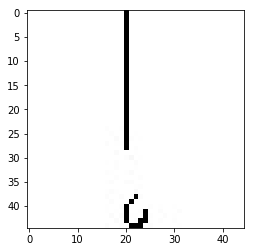

mathsymbol/(_10633.jpg


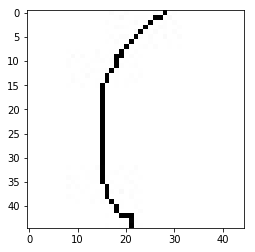

mathsymbol/)_12376.jpg


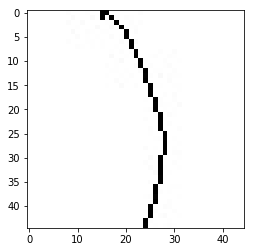

mathsymbol/+_22801.jpg


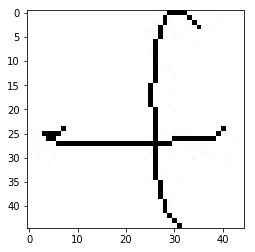

In [13]:
import glob
image_paths = sorted(glob.glob('mathsymbol/*.jpg'))
for i in (1,2000,18000,43284):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()
    im.close()

# Loading data

In [14]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

## sample_data

In [15]:
df_train = pd.read_csv('sample_data/sample_train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))
custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='sample_data/sample_train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=256, 
                          shuffle=True,
                          num_workers=4)


valid_dataset = QuickdrawDataset(csv_path='sample_data/sample_valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=256,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='sample_data/sample_test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=256,
                         shuffle=False,
                         num_workers=4)

Class distribution Train [ 117   46    8   24  103   98   49   14   12   56   10    2    3  185
  247   22 1383   22  171 1847   12  506  134  157  155   96    6   32
  114   35    3   27  160   77   75  146   45  810   19  743   21  141
  814   45   41]


## full_data

In [16]:
df_train = pd.read_csv('full_data/train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))
custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='full_data/train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=256, 
                          shuffle=True,
                          num_workers=4)


valid_dataset = QuickdrawDataset(csv_path='full_data/valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=256,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='full_data/test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=256,
                         shuffle=False,
                         num_workers=4)

Class distribution Train [ 1457   576    99   294  1283  1226   622   185   143   699   128    15
    34  2320  3083   271 17284   272  2144 23083   145  6313  1677  1974
  1935  1206    78   402  1435   438    32   344  2009   964   936  1831
   562 10129   237  9295   256  1764 10175   560   499]


In [17]:
#just check if data are loaded correctly
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 256
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 256
break minibatch for-loop


# hw4

In [18]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        #feature extract###############
        #arr_ = np.squeeze(features) # you can give axis attribute if you wanna squeeze in specific dimension
        #plt.imshow(arr_)
        #plt.show()
        ############################
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [19]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost


Epoch: 001/005 | Batch 0000/0432 | Cost: 3.8922
Epoch: 001/005 | Batch 0150/0432 | Cost: 0.2225
Epoch: 001/005 | Batch 0300/0432 | Cost: 0.1039
Epoch: 001/005 | Train: 98.257%
Time elapsed: 37.72 min
Epoch: 002/005 | Batch 0000/0432 | Cost: 0.0775
Epoch: 002/005 | Batch 0150/0432 | Cost: 0.1344
Epoch: 002/005 | Batch 0300/0432 | Cost: 0.1017
Epoch: 002/005 | Train: 98.893%
Time elapsed: 47.27 min
Epoch: 003/005 | Batch 0000/0432 | Cost: 0.0216
Epoch: 003/005 | Batch 0150/0432 | Cost: 0.0715
Epoch: 003/005 | Batch 0300/0432 | Cost: 0.0070
Epoch: 003/005 | Train: 99.431%
Time elapsed: 59.14 min
Epoch: 004/005 | Batch 0000/0432 | Cost: 0.0303
Epoch: 004/005 | Batch 0150/0432 | Cost: 0.0081
Epoch: 004/005 | Batch 0300/0432 | Cost: 0.0543
Epoch: 004/005 | Train: 99.569%
Time elapsed: 106.13 min
Epoch: 005/005 | Batch 0000/0432 | Cost: 0.0217
Epoch: 005/005 | Batch 0150/0432 | Cost: 0.0499
Epoch: 005/005 | Batch 0300/0432 | Cost: 0.0361
Epoch: 005/005 | Train: 99.556%
Time elapsed: 114.06 mi

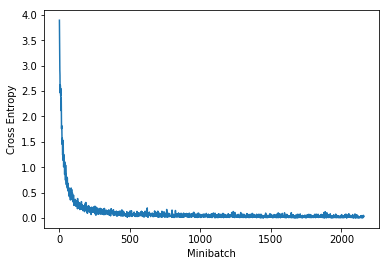

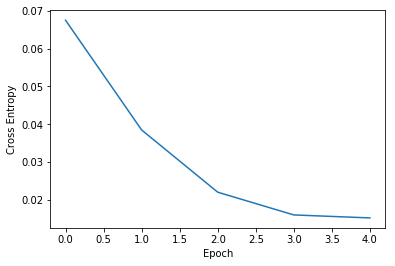

In [20]:
##########################
### MODEL
##########################

class ConvNet3(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet3, self).__init__()
        
        #### YOUR CODE
        self.conv0 = nn.Conv2d(1, 64, kernel_size=4, stride=3,padding=2)
        #self.pool0  = nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv1 =  nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=4,stride=2,padding=2)
        self.bn2   = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.linear1 = nn.Linear(256,2048)
        self.bnnl1   = nn.BatchNorm1d(2048)
        
        self.linear2 = nn.Linear(2048,2048)
        self.bnnl2   = nn.BatchNorm1d(2048)
        
        self.linear3 = nn.Linear(2048, num_classes)  

    def forward(self, x):

        #### YOUR CODE
        out = self.conv0(x)
        #print(out.size())
        out = self.relu(out)
        #out = self.pool0(out)
        #print(out.size())
        
        out = self.conv1(out)
        out = self.relu(out)
        out = self.pool1(out)
        #print(out.size())
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.dropout(out, p=0.2, training=self.training)
        out = self.relu(out)
        out = self.pool2(out)
        #print(out.size())
        
        out = self.linear1(out.view(out.size(0),256))
        #print(out.size())
        out = self.bnnl1(out)
        out = self.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        #print(out.size())
        
        out = self.linear2(out)
        out = self.bnnl2(out)
        out = self.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        #print(out.size())
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model3 = ConvNet3(NUM_CLASSES)
model3.to(DEVICE)

optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model3, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

# Save Model

In [26]:
model3.to(torch.device('cpu'))
torch.save(model3.state_dict(),'./zyc_model.pt')

# Reuse Model

In [28]:
model3=ConvNet3(NUM_CLASSES)
model3.load_state_dict(torch.load('./zyc_model.pt'))
model3=model3.to(DEVICE)

# Predict 

In [21]:
for root, dirs, files in os.walk('.'):
    for item in dirs:
        if (item[0]!='.'):
            try:
                os.remove(os.path.join(item,'.DS_Store'))
            except:
                pass

In [22]:
folders = os.listdir('extracted_images')
class_match = dict()
i = -1
for subfolder in folders:
    i += 1
    class_match[i] = subfolder

In [23]:
def predict(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        probas_read = pd.Series(probas.tolist()[0])
        class_label = pd.Series(list(range(NUM_CLASSES)))
        top3 = []
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-1]])[0]], sorted(probas_read)[-1]]]
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-2]])[0]], sorted(probas_read)[-2]]]
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-3]])[0]], sorted(probas_read)[-3]]]
        top3 = pd.DataFrame(top3)
        _, predicted_labels = torch.max(probas, 1)
        print('Predict class: ', class_match[int(predicted_labels)])
        top3.columns = ['Class', 'Probability']
        return top3

True class: +


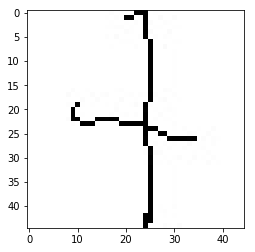

Predict class:  +


,Class,Probability
0,+,9.999902e-01
1,),5.530952e-06
2,],9.425868e-07


In [40]:
application_index = [43213]#<=153,354

image_paths = sorted(glob.glob('mathsymbol/*.jpg'))

with open('application.csv', mode='w') as app:
    app_writer = csv.writer(app, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    app_writer.writerow(['Filename', 'Class Label'])
    for image in application_index:
        app_writer.writerow([image_paths[image].split('/')[1], 0])
    
for i in application_index:
    im_path = image_paths[i]
    print('True class:', im_path.split('/')[1].split('_')[0])
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()
    
application_dataset = QuickdrawDataset(csv_path='application.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)
application_loader = DataLoader(dataset=application_dataset,
                          batch_size=1, 
                          shuffle=True,
                          num_workers=4)


predict(model3, application_loader, DEVICE) 

# Try yourself!

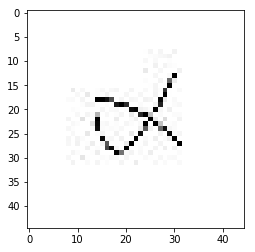

Predict class:  forward_slash


,Class,Probability
0,forward_slash,0.172825
1,ldots,0.171803
2,-,0.145169


In [57]:
img = Image.open('try/1.png')
rgb_im = img.convert('RGB').resize((45,45)).convert('L')
rgb_im.save('try/1.jpg', "JPEG", optimize=True)
img.close()


with open('application.csv', mode='w') as app:
    app_writer = csv.writer(app, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    app_writer.writerow(['Filename', 'Class Label'])
    app_writer.writerow(['1.jpg', 0])


im_path = 'try/1.jpg'
im = Image.open(im_path)
plt.imshow(im)
plt.show()
    
application_dataset = QuickdrawDataset(csv_path='application.csv',
                                 img_dir='try/',
                                 transform=custom_transform)
application_loader = DataLoader(dataset=application_dataset,
                          batch_size=1, 
                          shuffle=True,
                          num_workers=4)



predict(model3, application_loader, DEVICE) 